### Symbolic Regression Experiment
### Comparing Initialization Methods in Grammatical Evolution
### Overview

This notebook compares three population initialization methods for GE across **four benchmark problems**:

| Method | Description |
|--------|-------------|
| **Random** | Baseline - random integer genomes |
| **Sensible** | Ryan & Azad (2003) - grammar-aware |
| **PI-Grow** | Position Independent Grow |

### Benchmark Problems

| Problem | Description |
|---------|-------------|
| **Diabetes** | Scikit-learn benchmark dataset (10 features) |
| **Keijzer-6** | Harmonic series: $H_n = \sum_{i=1}^{n} \frac{1}{i}$ |
| **Nguyen-7** | $f(x) = \ln(x+1) + \ln(x^2+1)$ |
| **Pagie-1** | $f(x,y) = \frac{1}{1+x^{-4}} + \frac{1}{1+y^{-4}}$ |

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy, mannwhitneyu, kruskal
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import warnings
import time
from datetime import datetime

warnings.filterwarnings('ignore')
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Imports complete!")
print(f"Experiment date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Imports complete!
Experiment date: 2026-01-29 02:20


In [3]:
plt.rcParams.update({
    'figure.figsize': (12, 8), 'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11, 'axes.labelsize': 12, 'axes.titlesize': 13,
    'legend.fontsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'figure.dpi': 100, 'savefig.dpi': 300,
    'axes.spines.top': False, 'axes.spines.right': False,
})

COLORS = {'Random': '#E74C3C', 'Sensible': '#3498DB', 'PI-Grow': '#2ECC71'}
MARKERS = {'Random': 'o', 'Sensible': 's', 'PI-Grow': '^'}
print("Visual configuration set!")

Visual configuration set!


In [4]:
N_RUNS = 30
GENERATIONS = 50
POP_SIZE = 100
ELITE_SIZE = 5
GENOME_LENGTH = 100
MAX_DEPTH = 8
MAX_WRAPS = 2
CODON_SIZE = 256
TOURNAMENT_SIZE = 3
CROSSOVER_RATE = 0.9
MUTATION_RATE = 0.01

print("="*70)
print(" GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON")
print("="*70)
print(f"Runs: {N_RUNS}, Generations: {GENERATIONS}, Pop size: {POP_SIZE}")

 GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON
Runs: 30, Generations: 50, Pop size: 100


## Benchmark Problems Definition

In [8]:
# Problem 1: Diabetes Dataset (sklearn benchmark)
def load_diabetes_problem():
    diabetes = load_diabetes()
    X, y = diabetes.data, diabetes.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    return {'name': 'Diabetes', 'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test, 'n_features': 10, 'multivariate': True,
            'description': 'Scikit-learn benchmark dataset (10 features)'}

# Problem 2: Keijzer-6 (Harmonic Series)
def keijzer_6(x):
    return np.array([sum(1.0/i for i in range(1, int(xi)+1)) for xi in x])

def load_keijzer6_problem():
    X_train = np.linspace(1, 50, 50).reshape(-1, 1)
    y_train = keijzer_6(X_train.flatten())
    X_test = np.linspace(1, 120, 120).reshape(-1, 1)
    y_test = keijzer_6(X_test.flatten())
    return {'name': 'Keijzer-6', 'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test, 'n_features': 1, 'multivariate': False,
            'description': 'Harmonic series: H_n = sum(1/i)'}

# Problem 3: Nguyen-7
def nguyen_7(x):
    return np.log(x + 1) + np.log(x**2 + 1)

def load_nguyen7_problem():
    X_train = np.linspace(0, 2, 20).reshape(-1, 1)
    y_train = nguyen_7(X_train.flatten())
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    y_test = nguyen_7(X_test.flatten())
    return {'name': 'Nguyen-7', 'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test, 'n_features': 1, 'multivariate': False,
            'description': 'f(x) = ln(x+1) + ln(x^2+1)'}

# Problem 4: Pagie-1 (2D benchmark)
def pagie_1(X):
    x, y = X[:, 0], X[:, 1]
    return 1.0 / (1.0 + x**(-4)) + 1.0 / (1.0 + y**(-4))

def load_pagie1_problem():
    # Create 2D grid for training: [-5, 5] x [-5, 5] with step 0.4
    x_vals = np.arange(-5, 5.01, 0.4)
    y_vals = np.arange(-5, 5.01, 0.4)
    xx, yy = np.meshgrid(x_vals, y_vals)
    X_train = np.column_stack([xx.ravel(), yy.ravel()])
    y_train = pagie_1(X_train)
    
    # Create denser test grid
    x_test = np.arange(-5, 5.01, 0.2)
    y_test = np.arange(-5, 5.01, 0.2)
    xx_t, yy_t = np.meshgrid(x_test, y_test)
    X_test = np.column_stack([xx_t.ravel(), yy_t.ravel()])
    y_test_vals = pagie_1(X_test)
    
    return {'name': 'Pagie-1', 'X_train': X_train, 'y_train': y_train,
            'X_test': X_test, 'y_test': y_test_vals, 'n_features': 2, 'multivariate': True,
            'description': 'f(x,y) = 1/(1+x^-4) + 1/(1+y^-4)'}

PROBLEMS = {
    'Diabetes': load_diabetes_problem(),
    'Keijzer-6': load_keijzer6_problem(),
    'Nguyen-7': load_nguyen7_problem(),
    'Pagie-1': load_pagie1_problem()
}

print("\nBenchmark Problems Loaded:")
for name, prob in PROBLEMS.items():
    print(f"  {name}: {prob['description']}, Train: {len(prob['y_train'])}, Test: {len(prob['y_test'])}")


Benchmark Problems Loaded:
  Diabetes: Scikit-learn benchmark dataset (10 features), Train: 309, Test: 133
  Keijzer-6: Harmonic series: H_n = sum(1/i), Train: 50, Test: 120
  Nguyen-7: f(x) = ln(x+1) + ln(x^2+1), Train: 20, Test: 100
  Pagie-1: f(x,y) = 1/(1+x^-4) + 1/(1+y^-4), Train: 676, Test: 2601


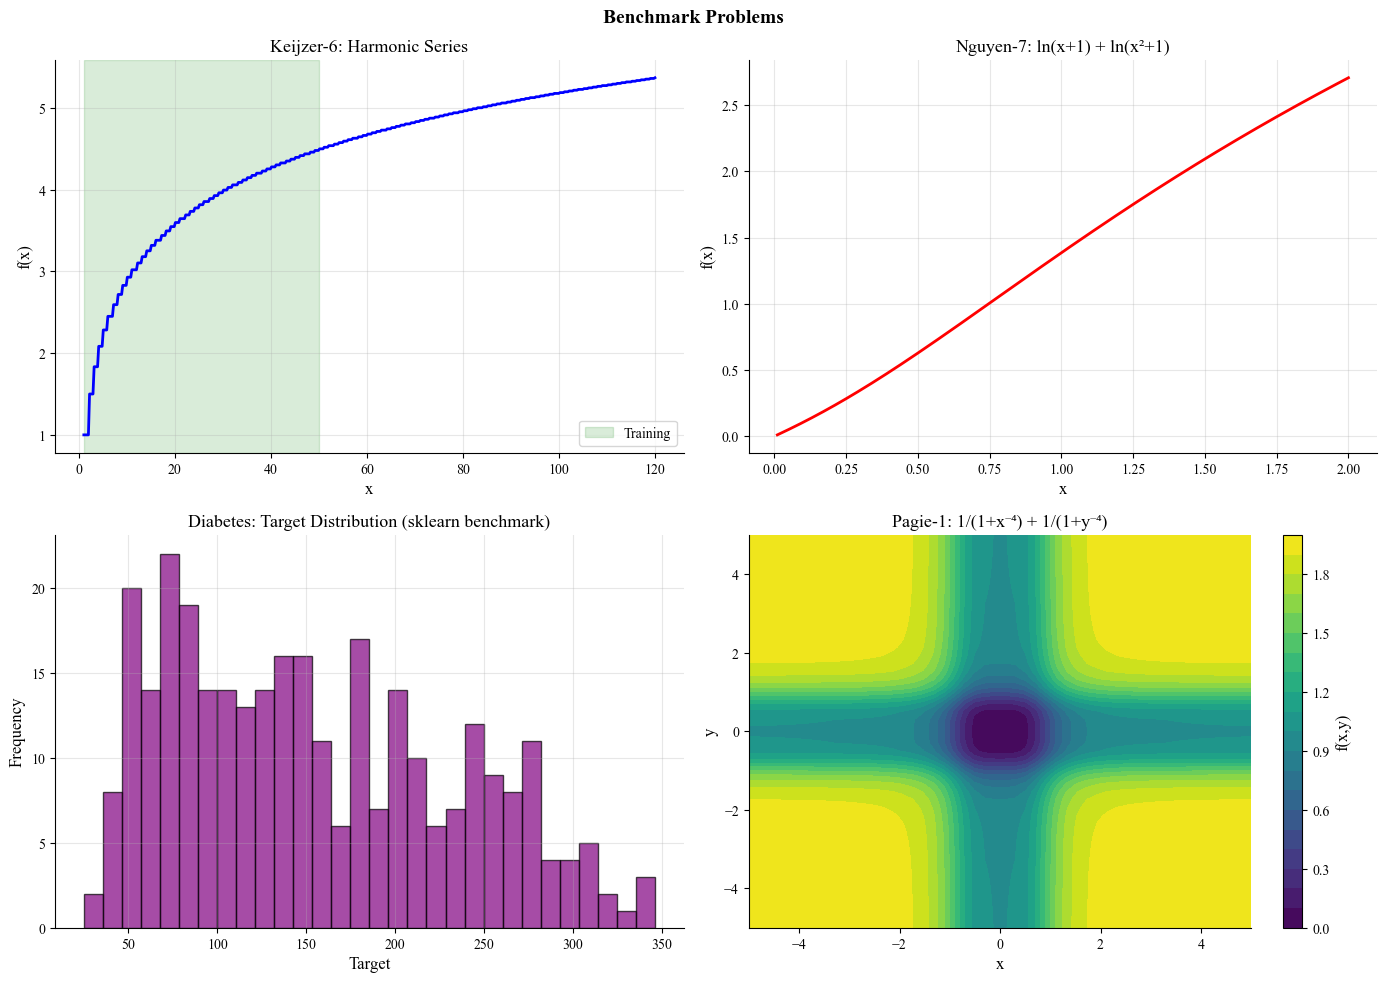

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Benchmark Problems', fontsize=14, fontweight='bold')

# Keijzer-6
ax = axes[0, 0]
x_plot = np.linspace(1, 120, 500)
ax.plot(x_plot, keijzer_6(x_plot), 'b-', linewidth=2)
ax.axvspan(1, 50, alpha=0.15, color='green', label='Training')
ax.set_xlabel('x'); ax.set_ylabel('f(x)'); ax.set_title('Keijzer-6: Harmonic Series')
ax.legend(); ax.grid(True, alpha=0.3)

# Nguyen-7
ax = axes[0, 1]
x_plot = np.linspace(0.01, 2, 200)
ax.plot(x_plot, nguyen_7(x_plot), 'r-', linewidth=2)
ax.set_xlabel('x'); ax.set_ylabel('f(x)'); ax.set_title('Nguyen-7: ln(x+1) + ln(x²+1)')
ax.grid(True, alpha=0.3)

# Diabetes
ax = axes[1, 0]
ax.hist(PROBLEMS['Diabetes']['y_train'], bins=30, alpha=0.7, color='purple', edgecolor='black')
ax.set_xlabel('Target'); ax.set_ylabel('Frequency'); ax.set_title('Diabetes: Target Distribution (sklearn benchmark)')
ax.grid(True, alpha=0.3)

# Pagie-1 (3D surface plot)
ax = axes[1, 1]
x_vals = np.linspace(-5, 5, 50)
y_vals = np.linspace(-5, 5, 50)
xx, yy = np.meshgrid(x_vals, y_vals)
X_grid = np.column_stack([xx.ravel(), yy.ravel()])
zz = pagie_1(X_grid).reshape(xx.shape)
c = ax.contourf(xx, yy, zz, levels=20, cmap='viridis')
plt.colorbar(c, ax=ax, label='f(x,y)')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_title('Pagie-1: 1/(1+x⁻⁴) + 1/(1+y⁻⁴)')

plt.tight_layout()
plt.show()

## Grammar and GE Components

In [10]:
class BNFGrammar:
    def __init__(self, grammar_dict, start_symbol=None):
        self.rules = grammar_dict
        self.non_terminals = list(self.rules.keys())
        self.start_symbol = start_symbol or self.non_terminals[0]
        self._precompute_rule_info()
    
    def _precompute_rule_info(self):
        self.terminal_indices = {}
        self.recursive_indices = {}
        for nt, prods in self.rules.items():
            self.terminal_indices[nt] = [i for i, prod in enumerate(prods) if not any(self._is_nt(s) for s in prod)]
            self.recursive_indices[nt] = [i for i, prod in enumerate(prods) if any(self._is_nt(s) for s in prod)]
    
    @staticmethod
    def _is_nt(symbol):
        return isinstance(symbol, str) and symbol.startswith('<') and symbol.endswith('>')
    
    def get_production(self, nt, codon): return self.rules[nt][codon % len(self.rules[nt])]
    def num_productions(self, nt): return len(self.rules[nt])

def create_grammar_multivariate(n_features):
    var_rules = [[f'x[:, {i}]'] for i in range(n_features)]
    return BNFGrammar({
        '<expr>': [['(', '<expr>', '<op>', '<expr>', ')'], ['<pre_op>', '(', '<expr>', ')'], ['<var>'], ['<const>']],
        '<op>': [['+'], ['-'], ['*'], ['pdiv']],
        '<pre_op>': [['np.sin'], ['np.cos'], ['np.log1p'], ['np.sqrt'], ['np.abs']],
        '<var>': var_rules,
        '<const>': [['1.0'], ['2.0'], ['0.5'], ['0.1'], ['np.pi'], ['np.e']]
    })

def create_grammar_univariate():
    return BNFGrammar({
        '<expr>': [['(', '<expr>', '<op>', '<expr>', ')'], ['<func>', '(', '<expr>', ')'], ['<var>'], ['<const>']],
        '<op>': [['+'], ['-'], ['*'], ['pdiv']],
        '<func>': [['np.log'], ['np.sqrt'], ['np.sin'], ['np.cos'], ['np.abs']],
        '<var>': [['x']],
        '<const>': [['1.0'], ['2.0'], ['0.5'], ['0.1'], ['np.e'], ['np.pi']]
    })

def get_grammar_for_problem(problem):
    return create_grammar_multivariate(problem['n_features']) if problem['multivariate'] else create_grammar_univariate()

print("Grammar classes defined!")

Grammar classes defined!


In [11]:
class Individual:
    def __init__(self, genome=None):
        self.genome = genome if genome is not None else []
        self.phenotype = None
        self.fitness = float('inf')
        self.valid = False
        self.depth = 0
        self.used_codons = 0
    
    def copy(self):
        ind = Individual(genome=self.genome.copy())
        ind.phenotype, ind.fitness, ind.valid = self.phenotype, self.fitness, self.valid
        ind.depth, ind.used_codons = self.depth, self.used_codons
        return ind

class GEMapper:
    def __init__(self, grammar, max_depth=10, max_wraps=2):
        self.grammar = grammar
        self.max_depth = max_depth
        self.max_wraps = max_wraps
        self.cache = {}
    
    def map(self, individual):
        genome_tuple = tuple(individual.genome)
        if genome_tuple in self.cache:
            cached = self.cache[genome_tuple]
            if cached is None:
                individual.valid = False
                return False
            individual.phenotype, individual.depth, individual.used_codons = cached
            individual.valid = True
            return True
        
        result = self._derive(individual.genome)
        if result is None:
            self.cache[genome_tuple] = None
            individual.valid = False
            return False
        
        self.cache[genome_tuple] = result
        individual.phenotype, individual.depth, individual.used_codons = result
        individual.valid = True
        return True
    
    def _derive(self, genome):
        if not genome: return None
        phenotype_parts, stack = [], [(self.grammar.start_symbol, 0)]
        codon_idx, genome_len, max_depth, wraps = 0, len(genome), 0, 0
        try:
            while stack:
                symbol, depth = stack.pop()
                max_depth = max(max_depth, depth)
                if depth > self.max_depth: return None
                if self.grammar._is_nt(symbol):
                    if symbol not in self.grammar.rules:
                        phenotype_parts.append(symbol)
                        continue
                    if codon_idx >= genome_len:
                        wraps += 1
                        if wraps > self.max_wraps: return None
                    codon = genome[codon_idx % genome_len]
                    codon_idx += 1
                    for s in reversed(self.grammar.get_production(symbol, codon)):
                        stack.append((s, depth + 1))
                else:
                    phenotype_parts.append(symbol)
            return ''.join(phenotype_parts), max_depth, codon_idx
        except: return None

print("GE Engine classes defined!")

GE Engine classes defined!


## Initialization Methods

In [12]:
def random_init(pop_size, genome_length, codon_size=256, **kwargs):
    return [Individual(genome=[random.randint(0, codon_size-1) for _ in range(genome_length)]) for _ in range(pop_size)]

def sensible_init(pop_size, genome_length, grammar, max_depth=6, codon_size=256, **kwargs):
    population = []
    for _ in range(pop_size):
        genome, queue = [], [(grammar.start_symbol, 0)]
        target_depth = random.randint(2, max_depth)
        while queue:
            symbol, depth = queue.pop(0)
            if symbol not in grammar.rules: continue
            num_prods = grammar.num_productions(symbol)
            terminal_idx = grammar.terminal_indices[symbol]
            rule_idx = random.choice(terminal_idx) if (depth >= target_depth and terminal_idx) else random.randint(0, num_prods-1)
            codon = (rule_idx + random.randint(0, (codon_size // num_prods) - 1) * num_prods) % codon_size
            genome.append(codon)
            for s in grammar.rules[symbol][rule_idx]:
                if grammar._is_nt(s): queue.append((s, depth + 1))
        while len(genome) < genome_length: genome.append(random.randint(0, codon_size-1))
        population.append(Individual(genome=genome[:genome_length]))
    return population

def pi_grow_init(pop_size, genome_length, grammar, max_depth=6, codon_size=256, **kwargs):
    population = []
    for _ in range(pop_size):
        genome, queue = [], [(grammar.start_symbol, 0)]
        while queue:
            random.shuffle(queue)
            symbol, depth = queue.pop(0)
            if symbol not in grammar.rules: continue
            num_prods = grammar.num_productions(symbol)
            if depth >= max_depth:
                min_nt, best_idx = float('inf'), []
                for i, prod in enumerate(grammar.rules[symbol]):
                    nt_count = sum(1 for s in prod if grammar._is_nt(s))
                    if nt_count < min_nt: min_nt, best_idx = nt_count, [i]
                    elif nt_count == min_nt: best_idx.append(i)
                rule_idx = random.choice(best_idx)
            else:
                rule_idx = random.randint(0, num_prods - 1)
            codon = (rule_idx + random.randint(0, (codon_size // num_prods) - 1) * num_prods) % codon_size
            genome.append(codon)
            for s in grammar.rules[symbol][rule_idx]:
                if grammar._is_nt(s): queue.append((s, depth + 1))
        while len(genome) < genome_length: genome.append(random.randint(0, codon_size-1))
        population.append(Individual(genome=genome[:genome_length]))
    return population

INIT_METHODS = {'Random': random_init, 'Sensible': sensible_init, 'PI-Grow': pi_grow_init}
print("Initialization methods defined: Random, Sensible, PI-Grow")

Initialization methods defined: Random, Sensible, PI-Grow


## Fitness and Genetic Operators

In [13]:
def pdiv(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(b) > 1e-10, a / b, 1.0)
        return np.nan_to_num(result, nan=1.0, posinf=1e10, neginf=-1e10)

EVAL_CONTEXT = {'np': np, 'pdiv': pdiv, '__builtins__': {}}

class FitnessEvaluator:
    def __init__(self, X, y, multivariate=False):
        self.X, self.y, self.multivariate, self.cache = X, y, multivariate, {}
    
    def evaluate(self, phenotype):
        if phenotype is None: return float('inf')
        if phenotype in self.cache: return self.cache[phenotype]
        try:
            local_context = {'x': self.X if self.multivariate else self.X.flatten()}
            pred = eval(phenotype, EVAL_CONTEXT, local_context)
            if np.isscalar(pred): pred = np.full_like(self.y, pred)
            pred = np.asarray(pred).flatten()
            if len(pred) != len(self.y): return float('inf')
            pred = np.nan_to_num(np.clip(pred, -1e10, 1e10), nan=1e10, posinf=1e10, neginf=-1e10)
            rmse = np.sqrt(np.mean((pred - self.y) ** 2))
            self.cache[phenotype] = min(rmse, 1e10)
            return self.cache[phenotype]
        except:
            self.cache[phenotype] = float('inf')
            return float('inf')
    
    def evaluate_individual(self, individual, mapper):
        individual.fitness = self.evaluate(individual.phenotype) if mapper.map(individual) else float('inf')
        return individual.fitness

def tournament_selection(population, tournament_size=3):
    return min(random.sample(population, min(tournament_size, len(population))), key=lambda ind: ind.fitness).copy()

def one_point_crossover(parent1, parent2, crossover_rate=0.9):
    if random.random() > crossover_rate: return parent1.copy(), parent2.copy()
    min_len = min(len(parent1.genome), len(parent2.genome))
    if min_len <= 1: return parent1.copy(), parent2.copy()
    point = random.randint(1, min_len - 1)
    return Individual(genome=parent1.genome[:point] + parent2.genome[point:]), Individual(genome=parent2.genome[:point] + parent1.genome[point:])

def point_mutation(individual, mutation_rate=0.01, codon_size=256):
    new_genome = [random.randint(0, codon_size-1) if random.random() < mutation_rate else g for g in individual.genome]
    return Individual(genome=new_genome)

print("Fitness evaluator and genetic operators defined!")

Fitness evaluator and genetic operators defined!


## Evolutionary Algorithm

In [14]:
def run_evolution(init_func, init_name, grammar, problem, generations=GENERATIONS, pop_size=POP_SIZE, elite_size=ELITE_SIZE):
    mapper = GEMapper(grammar, MAX_DEPTH, MAX_WRAPS)
    evaluator = FitnessEvaluator(problem['X_train'], problem['y_train'], problem['multivariate'])
    
    population = init_func(pop_size, GENOME_LENGTH, CODON_SIZE) if init_name == 'Random' else init_func(pop_size, GENOME_LENGTH, grammar, MAX_DEPTH, CODON_SIZE)
    
    history = {'best_fitness': [], 'mean_fitness': [], 'validity_rate': [], 'diversity': [], 'best_phenotype': []}
    
    for gen in range(generations):
        for ind in population:
            if ind.fitness == float('inf'): evaluator.evaluate_individual(ind, mapper)
        population.sort(key=lambda x: x.fitness)
        
        valid_pop = [ind for ind in population if ind.valid and ind.fitness < 1e10]
        history['best_fitness'].append(population[0].fitness)
        history['mean_fitness'].append(np.mean([ind.fitness for ind in valid_pop]) if valid_pop else 1e10)
        history['validity_rate'].append(len(valid_pop) / pop_size)
        history['best_phenotype'].append(population[0].phenotype)
        
        phenotypes = [ind.phenotype for ind in valid_pop]
        history['diversity'].append(entropy(list(Counter(phenotypes).values())) if phenotypes else 0)
        
        next_gen = [ind.copy() for ind in population[:elite_size]]
        while len(next_gen) < pop_size:
            p1, p2 = tournament_selection(population, TOURNAMENT_SIZE), tournament_selection(population, TOURNAMENT_SIZE)
            c1, c2 = one_point_crossover(p1, p2, CROSSOVER_RATE)
            next_gen.extend([point_mutation(c1, MUTATION_RATE, CODON_SIZE), point_mutation(c2, MUTATION_RATE, CODON_SIZE)])
        population = next_gen[:pop_size]
    
    for ind in population: evaluator.evaluate_individual(ind, mapper)
    population.sort(key=lambda x: x.fitness)
    
    test_evaluator = FitnessEvaluator(problem['X_test'], problem['y_test'], problem['multivariate'])
    test_rmse = test_evaluator.evaluate(population[0].phenotype)
    
    return {'history': history, 'best_individual': population[0], 'test_rmse': test_rmse}

print("Evolutionary algorithm defined!")

Evolutionary algorithm defined!


## Run the Experiment

In [15]:
def run_full_experiment():
    print("="*70)
    print(" RUNNING EXPERIMENT: 4 Problems x 3 Methods x 30 Runs")
    print("="*70)
    
    all_results = {}
    total_start = time.time()
    
    for prob_name, problem in PROBLEMS.items():
        print(f"\n{'#'*60}\n# PROBLEM: {prob_name}\n{'#'*60}")
        grammar = get_grammar_for_problem(problem)
        problem_results = {}
        
        for method_name, init_func in INIT_METHODS.items():
            print(f"\n  Running {method_name}...", end=" ")
            method_runs = []
            for run in range(N_RUNS):
                random.seed(SEED + run)
                np.random.seed(SEED + run)
                run_result = run_evolution(init_func, method_name, grammar, problem)
                method_runs.append(run_result)
                if (run + 1) % 10 == 0: print(f"{run+1}", end=" ")
            problem_results[method_name] = method_runs
            print(f"Done!")
        all_results[prob_name] = problem_results
    
    print(f"\n{'='*70}\nCompleted in {(time.time() - total_start)/60:.2f} minutes\n{'='*70}")
    return all_results

all_results = run_full_experiment()

 RUNNING EXPERIMENT: 4 Problems x 3 Methods x 30 Runs

############################################################
# PROBLEM: Diabetes
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

  Running PI-Grow... 10 20 30 Done!

############################################################
# PROBLEM: Keijzer-6
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

  Running PI-Grow... 10 20 30 Done!

############################################################
# PROBLEM: Nguyen-7
############################################################

  Running Random... 10 20 30 Done!

  Running Sensible... 10 20 30 Done!

  Running PI-Grow... 10 20 30 Done!

############################################################
# PROBLEM: Pagie-1
############################################################

  Running Random... 10 20 30 Done!

  Ru

## Statistical Analysis

In [16]:
def analyze_results(results, problem_name):
    print(f"\n{'='*70}\n STATISTICAL ANALYSIS: {problem_name}\n{'='*70}")
    methods = list(results.keys())
    
    final_fitness = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    test_fitness = {m: [r['test_rmse'] for r in results[m]] for m in methods}
    init_validity = {m: [r['history']['validity_rate'][0] for r in results[m]] for m in methods}
    
    print("\n1. Training RMSE Summary")
    print("-"*65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-"*65)
    for m in methods:
        d = final_fitness[m]
        print(f"{m:<12} {np.mean(d):>12.4f} {np.std(d):>12.4f} {np.min(d):>12.4f} {np.max(d):>12.4f}")
    
    print("\n2. Test RMSE Summary")
    print("-"*65)
    print(f"{'Method':<12} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
    print("-"*65)
    for m in methods:
        d = [x for x in test_fitness[m] if x < 1e6]
        if d: print(f"{m:<12} {np.mean(d):>12.4f} {np.std(d):>12.4f} {np.min(d):>12.4f} {np.max(d):>12.4f}")
    
    print("\n3. Initial Validity Rates")
    print("-"*40)
    for m in methods:
        d = init_validity[m]
        print(f"{m:<12} {np.mean(d)*100:>8.1f}% +/- {np.std(d)*100:.1f}%")
    
    print("\n4. Mann-Whitney U Tests (Training RMSE)")
    print("-"*65)
    for m1, m2 in [('Random', 'Sensible'), ('Random', 'PI-Grow'), ('Sensible', 'PI-Grow')]:
        stat, p = mannwhitneyu(final_fitness[m1], final_fitness[m2], alternative='two-sided')
        sig = "Significant" if p < 0.05 else "Not significant"
        print(f"   {m1} vs {m2}: U={stat:.1f}, p={p:.4f} ({sig})")
    
    print("\n5. Kruskal-Wallis Test")
    stat, p = kruskal(*[final_fitness[m] for m in methods])
    print(f"   H={stat:.2f}, p={p:.4f} ({'Significant' if p < 0.05 else 'Not significant'})")
    
    return final_fitness, test_fitness, init_validity

stats_results = {}
for prob_name, results in all_results.items():
    stats_results[prob_name] = analyze_results(results, prob_name)


 STATISTICAL ANALYSIS: Diabetes

1. Training RMSE Summary
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           154.9297      23.6782      78.4180     169.9331
Sensible         155.5672      22.3928      96.6428     169.9331
PI-Grow          140.3316      35.1664      78.1127     169.9331

2. Test RMSE Summary
-----------------------------------------------------------------
Method               Mean          Std          Min          Max
-----------------------------------------------------------------
Random           147.5097      23.3675      73.7993     162.4463
Sensible         148.0528      22.3883      89.2190     162.4463
PI-Grow          133.2355      34.4273      73.4420     162.4463

3. Initial Validity Rates
----------------------------------------
Random           84.4% +/- 2.9%
Sensible         83.2% +/- 3.3%
PI-

## Visualizations

Saved: convergence_all_problems.png


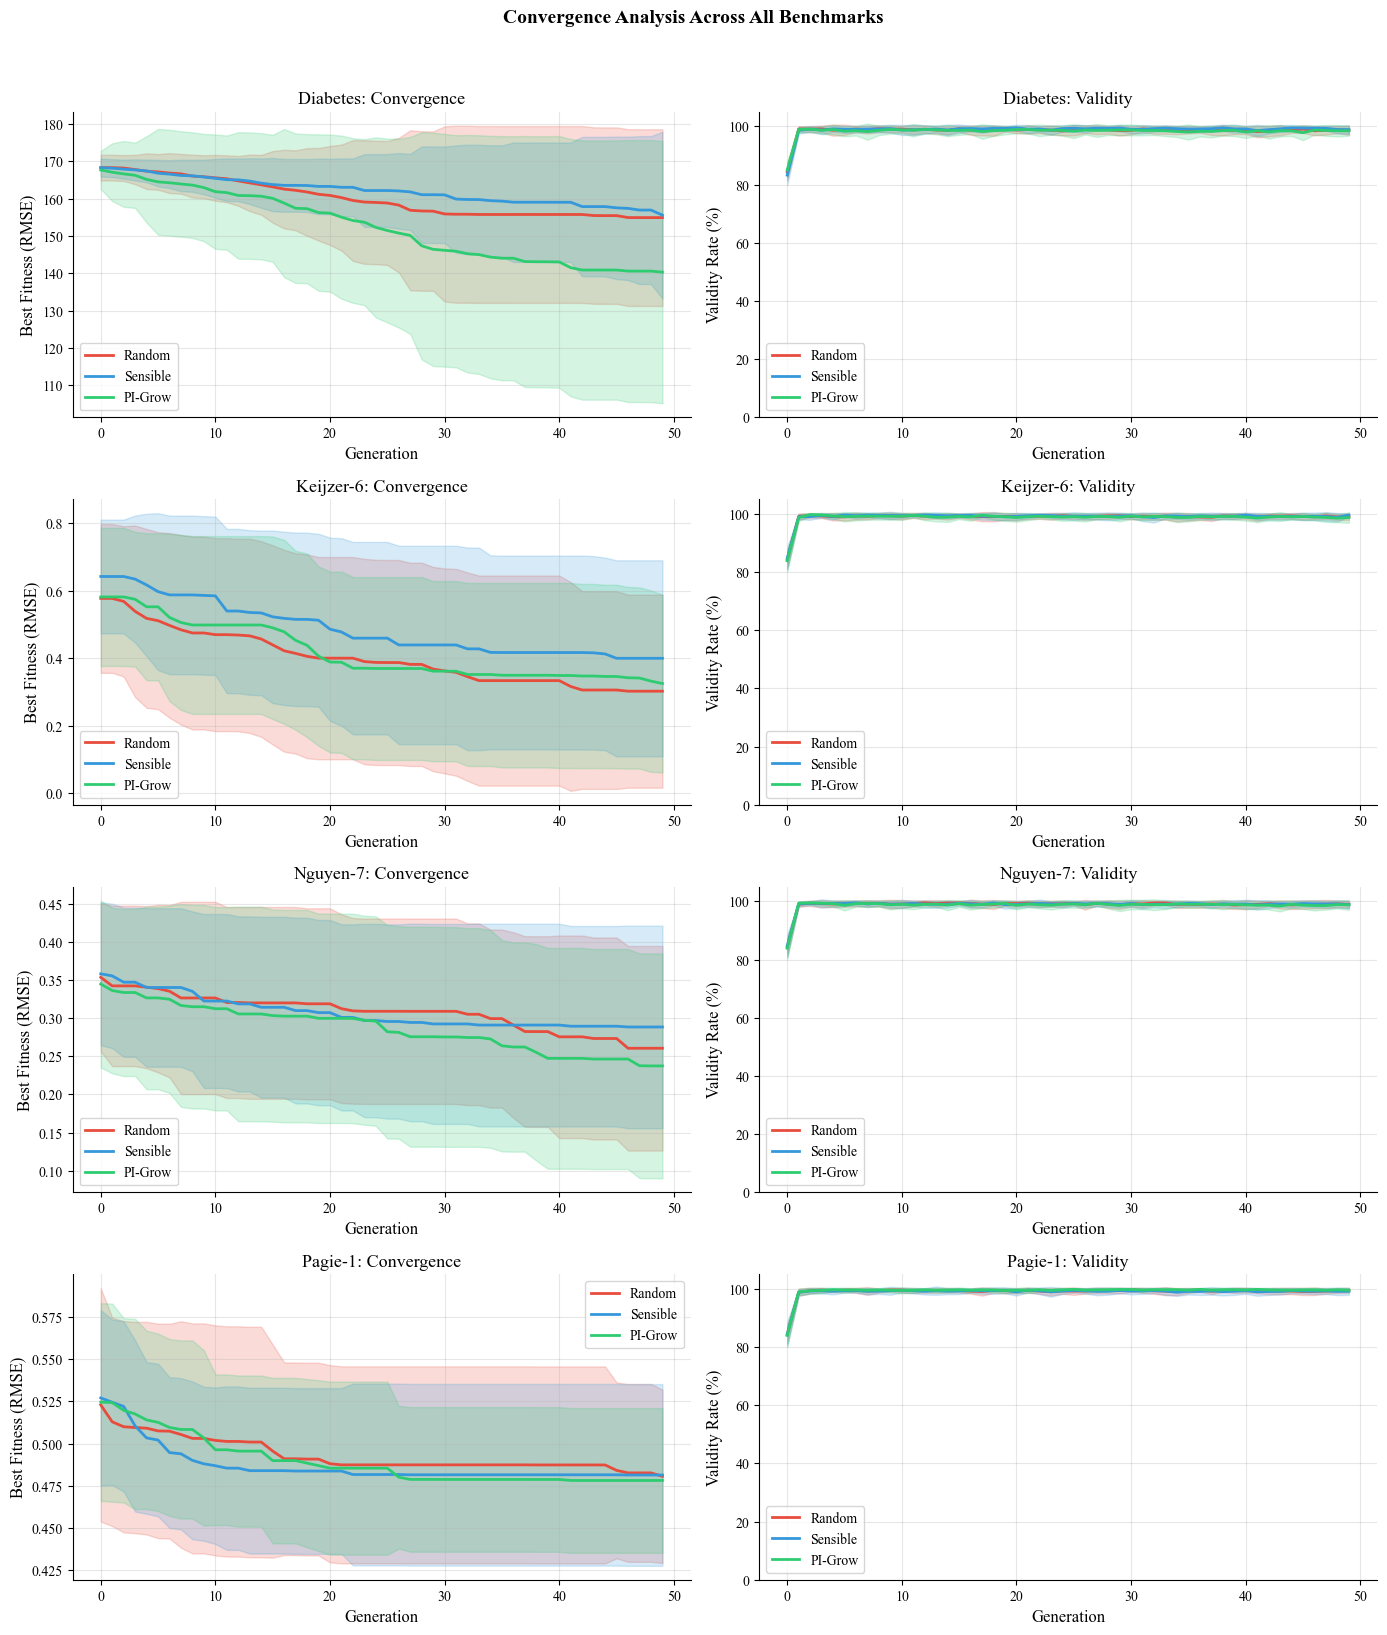

In [17]:
fig, axes = plt.subplots(len(PROBLEMS), 2, figsize=(14, 4*len(PROBLEMS)))
fig.suptitle('Convergence Analysis Across All Benchmarks', fontsize=14, fontweight='bold', y=1.02)

for row, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    generations = len(results[methods[0]][0]['history']['best_fitness'])
    
    ax = axes[row, 0]
    for m in methods:
        curves = np.array([r['history']['best_fitness'] for r in results[m]])
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        x = np.arange(generations)
        ax.plot(x, mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(x, mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Best Fitness (RMSE)')
    ax.set_title(f'{prob_name}: Convergence'); ax.legend(); ax.grid(True, alpha=0.3)
    
    ax = axes[row, 1]
    for m in methods:
        curves = np.array([r['history']['validity_rate'] for r in results[m]]) * 100
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        ax.plot(np.arange(generations), mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(np.arange(generations), mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Validity Rate (%)')
    ax.set_title(f'{prob_name}: Validity'); ax.legend(); ax.set_ylim([0, 105]); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('convergence_all_problems.png', dpi=300, bbox_inches='tight')
print("Saved: convergence_all_problems.png")
plt.show()

Saved: boxplots_all_problems.png


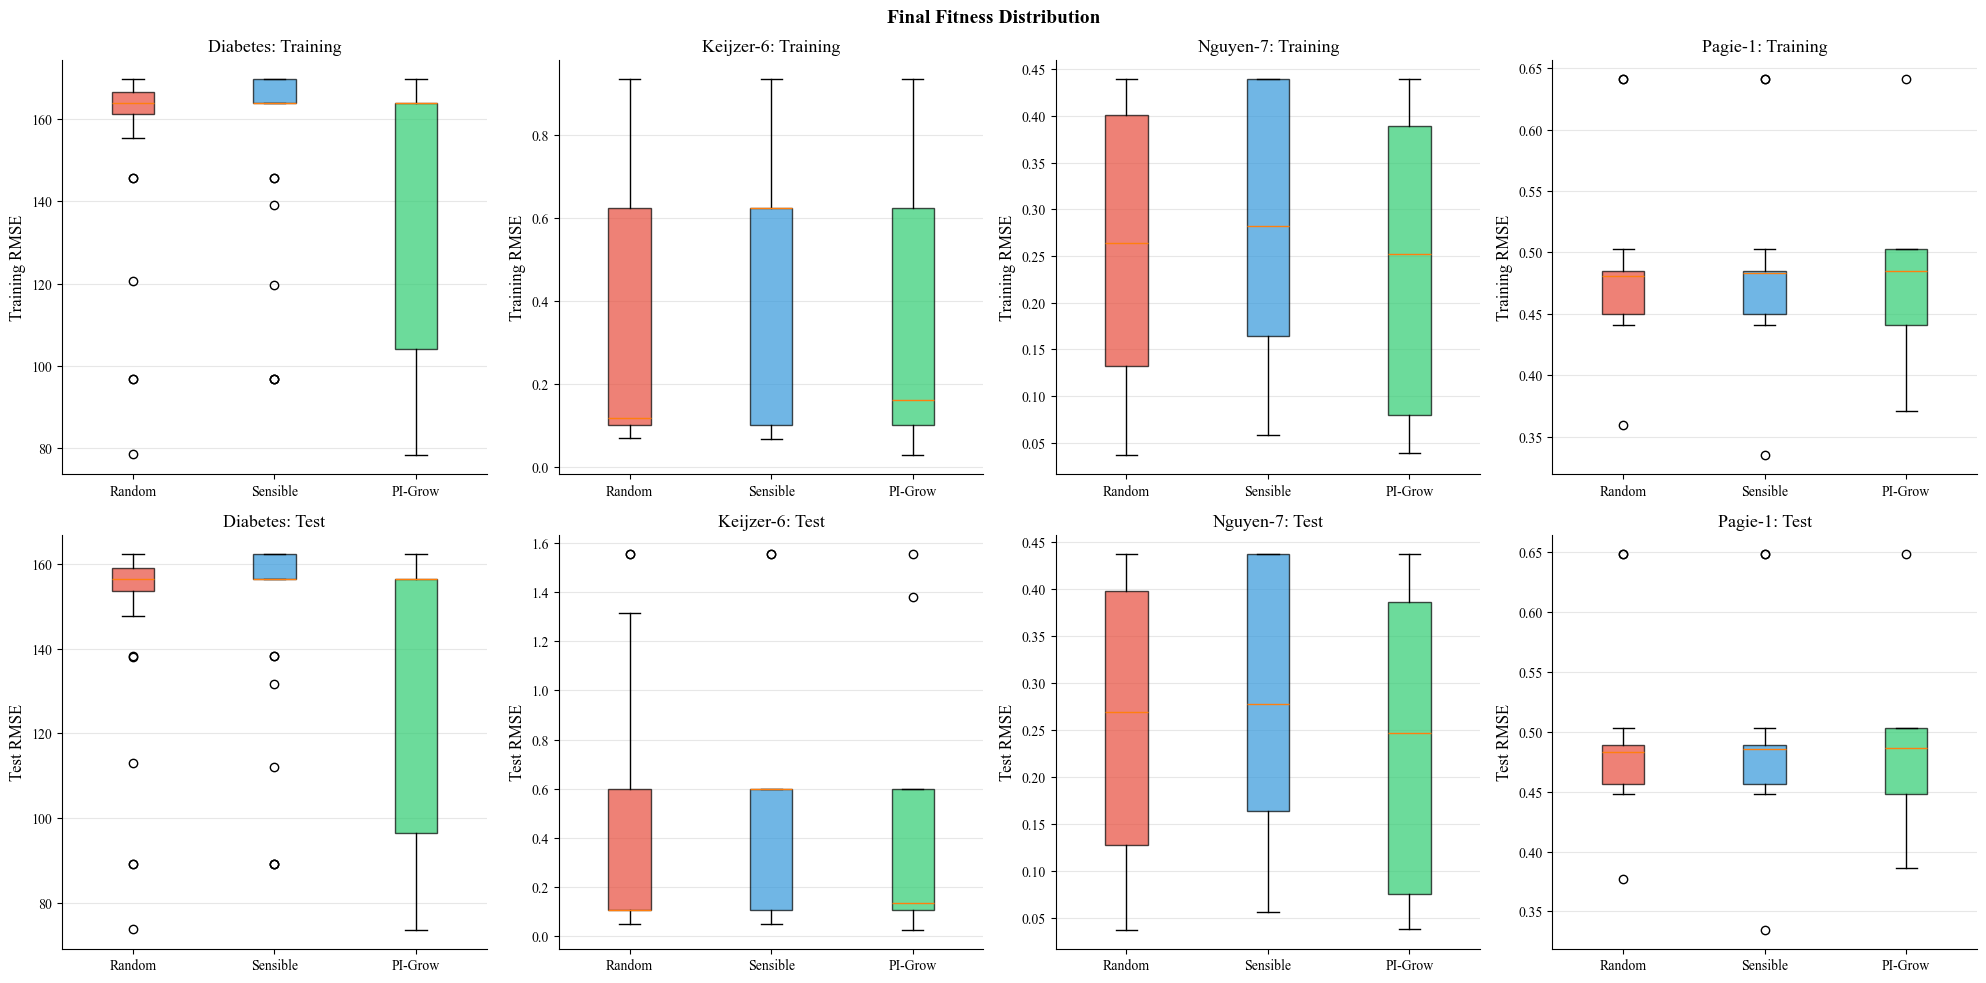

In [18]:
fig, axes = plt.subplots(2, len(PROBLEMS), figsize=(5*len(PROBLEMS), 10))
fig.suptitle('Final Fitness Distribution', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    
    ax = axes[0, col]
    bp = ax.boxplot([[r['best_individual'].fitness for r in results[m]] for m in methods], labels=methods, patch_artist=True)
    for patch, m in zip(bp['boxes'], methods): patch.set_facecolor(COLORS[m]); patch.set_alpha(0.7)
    ax.set_ylabel('Training RMSE'); ax.set_title(f'{prob_name}: Training'); ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, col]
    bp = ax.boxplot([[r['test_rmse'] for r in results[m]] for m in methods], labels=methods, patch_artist=True)
    for patch, m in zip(bp['boxes'], methods): patch.set_facecolor(COLORS[m]); patch.set_alpha(0.7)
    ax.set_ylabel('Test RMSE'); ax.set_title(f'{prob_name}: Test'); ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('boxplots_all_problems.png', dpi=300, bbox_inches='tight')
print("Saved: boxplots_all_problems.png")
plt.show()

Saved: initialization_analysis.png


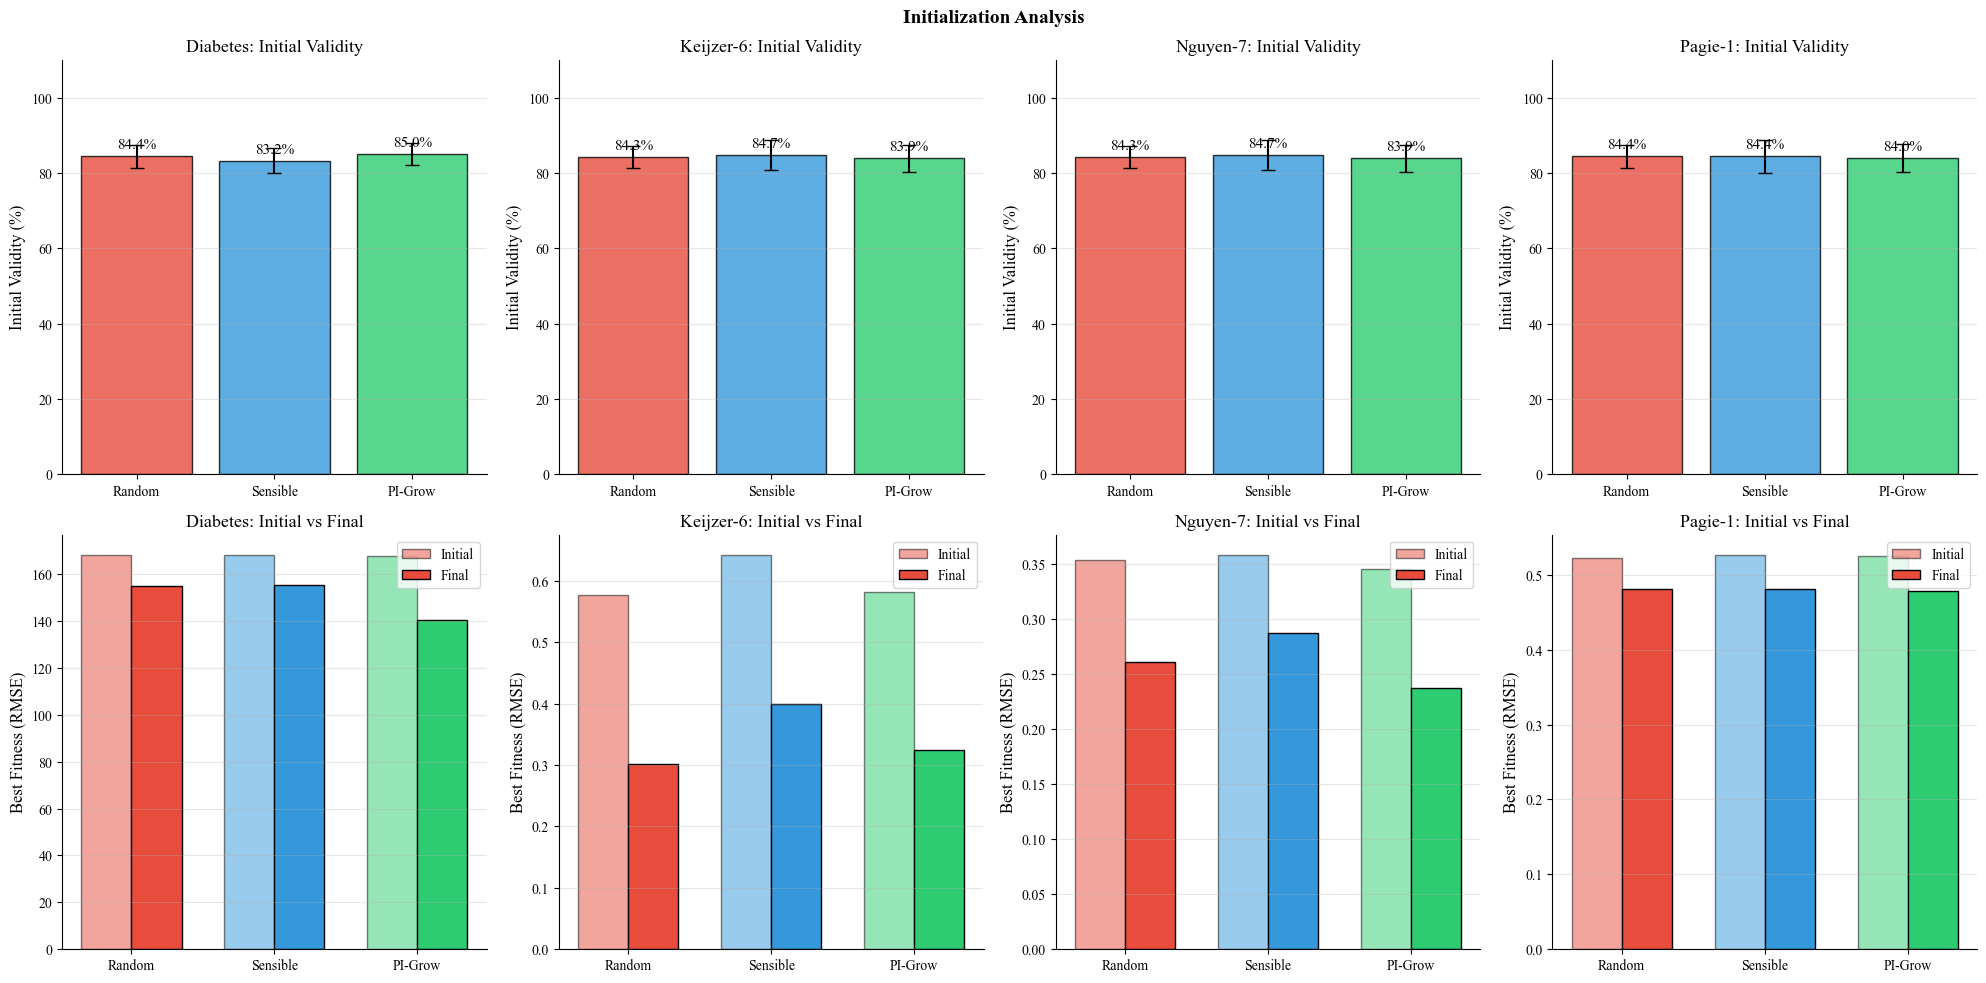

In [19]:
fig, axes = plt.subplots(2, len(PROBLEMS), figsize=(5*len(PROBLEMS), 10))
fig.suptitle('Initialization Analysis', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    methods = list(results.keys())
    
    ax = axes[0, col]
    validity = {m: [r['history']['validity_rate'][0]*100 for r in results[m]] for m in methods}
    means, stds = [np.mean(validity[m]) for m in methods], [np.std(validity[m]) for m in methods]
    bars = ax.bar(methods, means, yerr=stds, capsize=5, color=[COLORS[m] for m in methods], alpha=0.8, edgecolor='black')
    for bar, mean in zip(bars, means): ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+2, f'{mean:.1f}%', ha='center')
    ax.set_ylabel('Initial Validity (%)'); ax.set_title(f'{prob_name}: Initial Validity'); ax.set_ylim([0, 110]); ax.grid(True, alpha=0.3, axis='y')
    
    ax = axes[1, col]
    init_fit = {m: [r['history']['best_fitness'][0] for r in results[m]] for m in methods}
    final_fit = {m: [r['best_individual'].fitness for r in results[m]] for m in methods}
    x, width = np.arange(len(methods)), 0.35
    ax.bar(x-width/2, [np.mean(init_fit[m]) for m in methods], width, label='Initial', color=[COLORS[m] for m in methods], alpha=0.5, edgecolor='black')
    ax.bar(x+width/2, [np.mean(final_fit[m]) for m in methods], width, label='Final', color=[COLORS[m] for m in methods], alpha=1.0, edgecolor='black')
    ax.set_xticks(x); ax.set_xticklabels(methods)
    ax.set_ylabel('Best Fitness (RMSE)'); ax.set_title(f'{prob_name}: Initial vs Final'); ax.legend(); ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('initialization_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: initialization_analysis.png")
plt.show()

Saved: diversity_analysis.png


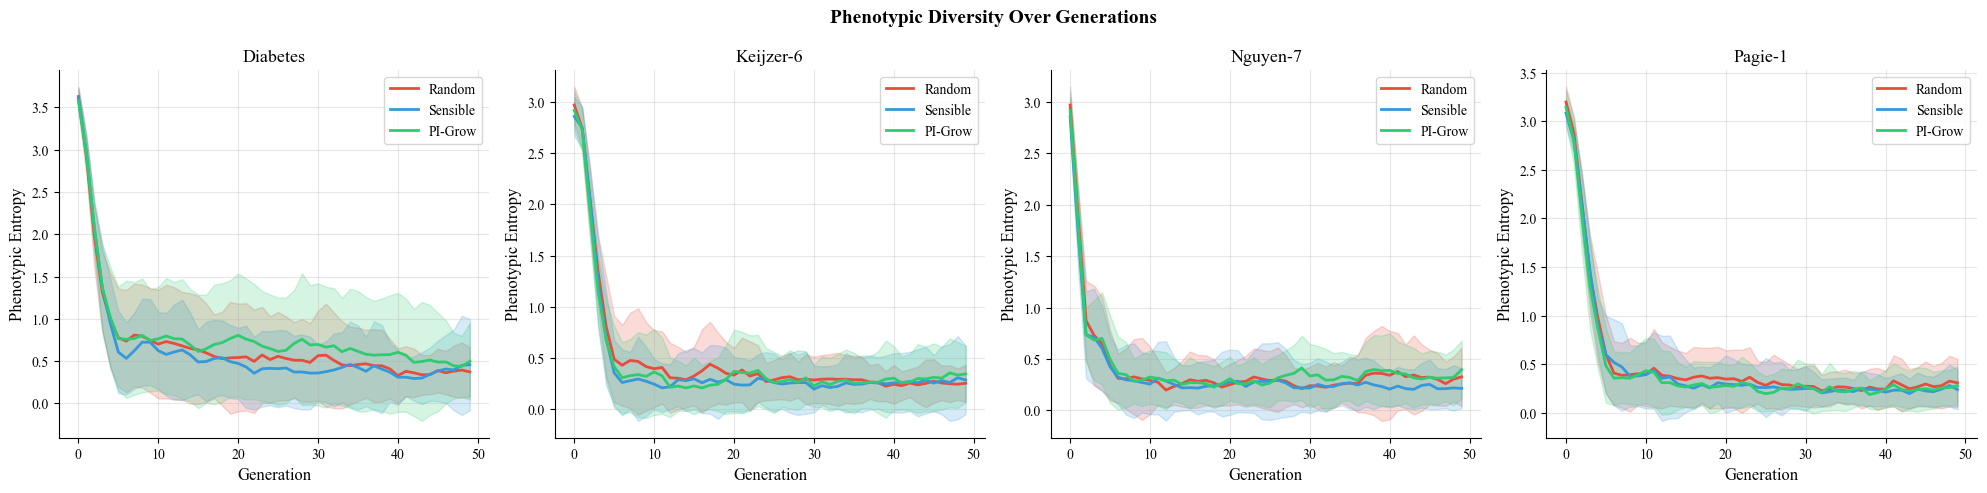

In [20]:
fig, axes = plt.subplots(1, len(PROBLEMS), figsize=(5*len(PROBLEMS), 5))
fig.suptitle('Phenotypic Diversity Over Generations', fontsize=14, fontweight='bold')

for col, (prob_name, results) in enumerate(all_results.items()):
    ax = axes[col]
    methods = list(results.keys())
    generations = len(results[methods[0]][0]['history']['diversity'])
    
    for m in methods:
        curves = np.array([r['history']['diversity'] for r in results[m]])
        mean, std = np.mean(curves, axis=0), np.std(curves, axis=0)
        ax.plot(np.arange(generations), mean, label=m, color=COLORS[m], linewidth=2)
        ax.fill_between(np.arange(generations), mean-std, mean+std, color=COLORS[m], alpha=0.2)
    ax.set_xlabel('Generation'); ax.set_ylabel('Phenotypic Entropy')
    ax.set_title(f'{prob_name}'); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('diversity_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: diversity_analysis.png")
plt.show()

## Best Solutions

In [21]:
print("\n" + "="*70 + "\n BEST SOLUTIONS FOUND\n" + "="*70)

for prob_name, results in all_results.items():
    print(f"\n{'#'*60}\n# {prob_name}\n{'#'*60}")
    for method in results:
        best_run = min(results[method], key=lambda r: r['best_individual'].fitness)
        best = best_run['best_individual']
        pheno = (best.phenotype[:70] + "...") if best.phenotype and len(best.phenotype) > 70 else (best.phenotype or "N/A")
        print(f"\n  {method}: Train={best.fitness:.6f}, Test={best_run['test_rmse']:.6f}")
        print(f"  Phenotype: {pheno}")


 BEST SOLUTIONS FOUND

############################################################
# Diabetes
############################################################

  Random: Train=78.417990, Test=73.799256
  Phenotype: ((np.cos(x[:, 1])+(np.pi*(np.e*np.pi)))*(np.sqrt(np.abs(np.pi))*np.pi)...

  Sensible: Train=96.642815, Test=89.219004
  Phenotype: (np.pi*((np.pi*np.pi)*np.pi))

  PI-Grow: Train=78.112723, Test=73.468485
  Phenotype: (np.abs((np.pi+np.abs(2.0)))*(((np.pi*np.e)*np.pi)-(((x[:, 6]-2.0)*np....

############################################################
# Keijzer-6
############################################################

  Random: Train=0.068291, Test=0.048731
  Phenotype: np.log((x+(x*np.sin(1.0))))

  Sensible: Train=0.067896, Test=0.049787
  Phenotype: (np.log(x)+np.cos(np.sin(2.0)))

  PI-Grow: Train=0.027134, Test=0.024217
  Phenotype: np.log(np.sqrt(((2.0-np.cos(np.pi))*(x*(x+2.0)))))

############################################################
# Nguyen-7
##########

## Summary Tables

In [22]:
print("\n" + "="*70 + "\n EXPERIMENT SUMMARY\n" + "="*70)

problems = list(all_results.keys())
methods = list(all_results[problems[0]].keys())

print("\nMean Training RMSE (Std):")
print("-"*75)
header = f"{'Method':<12}" + "".join([f"{p:>20}" for p in problems])
print(header)
print("-"*75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        f = [r['best_individual'].fitness for r in all_results[p][m]]
        row += f"{np.mean(f):>10.2f} ({np.std(f):.2f})"
    print(row)

print("\nMean Test RMSE (Std):")
print("-"*75)
print(header)
print("-"*75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        f = [r['test_rmse'] for r in all_results[p][m]]
        row += f"{np.mean(f):>10.2f} ({np.std(f):.2f})"
    print(row)

print("\nInitial Validity Rate (%):")
print("-"*75)
print(header)
print("-"*75)
for m in methods:
    row = f"{m:<12}"
    for p in problems:
        v = [r['history']['validity_rate'][0]*100 for r in all_results[p][m]]
        row += f"{np.mean(v):>10.1f} ({np.std(v):.1f})"
    print(row)

print("\n" + "="*70 + "\n EXPERIMENT COMPLETE!\n" + "="*70)


 EXPERIMENT SUMMARY

Mean Training RMSE (Std):
---------------------------------------------------------------------------
Method                  Diabetes           Keijzer-6            Nguyen-7             Pagie-1
---------------------------------------------------------------------------
Random          154.93 (23.68)      0.30 (0.29)      0.26 (0.13)      0.48 (0.05)
Sensible        155.57 (22.39)      0.40 (0.29)      0.29 (0.13)      0.48 (0.05)
PI-Grow         140.33 (35.17)      0.33 (0.26)      0.24 (0.15)      0.48 (0.04)

Mean Test RMSE (Std):
---------------------------------------------------------------------------
Method                  Diabetes           Keijzer-6            Nguyen-7             Pagie-1
---------------------------------------------------------------------------
Random          147.51 (23.37)      0.41 (0.48)      0.26 (0.13)      0.49 (0.05)
Sensible        148.05 (22.39)      0.43 (0.39)      0.28 (0.13)      0.49 (0.05)
PI-Grow         133.24 (34.43